<a href="https://colab.research.google.com/gist/716352166/4b39189e3b1198be0829f908d79174f6/homework1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


جاري تدريب النموذج...
Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 43s 96ms/step - accuracy: 0.7337 - loss: 0.8208 - val_accuracy: 0.9822 - val_loss: 0.0648
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 39s 93ms/step - accuracy: 0.9636 - loss: 0.1301 - val_accuracy: 0.9867 - val_loss: 0.0429
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 93ms/step - accuracy: 0.9770 - loss: 0.0836 - val_accuracy: 0.9890 - val_loss: 0.0392
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 93ms/step - accuracy: 0.9808 - loss: 0.0695 - val_accuracy: 0.9882 - val_loss: 0.0416
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 94ms/step - accuracy: 0.9844 - loss: 0.0553 - val_accuracy: 0.9910 - val_loss: 0.0343
دقة النموذج على بيانات الاختبار: 0.9911
الرجاء رفع صورة تحتوي على أرقام متعددة:


Saving 20250901_003343.png to 20250901_003343.png

جاري معالجة الصورة: 20250901_003343.png


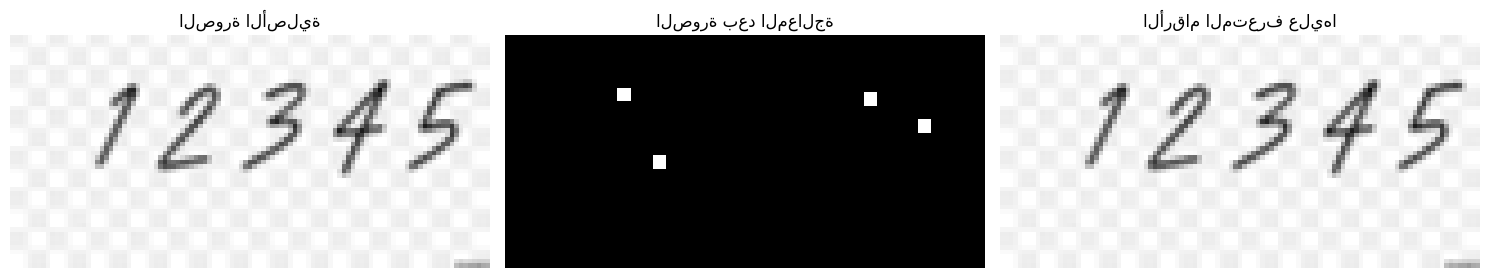


نتائج التعرف على الأرقام:

النص الكامل: 


In [1]:

# -*- coding: utf-8 -*-
"""التعرف على جميع الأرقام في الصورة.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1Y8rMZgJ7dF6Zz6Q8Q2vX2vZvQ2vZvQ2v
"""

# تحميل المكتبات المطلوبة
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageOps
from google.colab import files
from skimage import measure
from skimage.segmentation import clear_border
import matplotlib.patches as patches

# تحميل مجموعة بيانات MNIST
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# معالجة البيانات
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)
y_train_categorical = keras.utils.to_categorical(y_train, 10)
y_test_categorical = keras.utils.to_categorical(y_test, 10)

# بناء النموذج
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

# تجميع وتدريب النموذج
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# تدريب النموذج
print("جاري تدريب النموذج...")
history = model.fit(X_train, y_train_categorical,
                    batch_size=128,
                    epochs=5,
                    validation_split=0.1,
                    verbose=1)

# تقييم النموذج
test_loss, test_acc = model.evaluate(X_test, y_test_categorical, verbose=0)
print(f'دقة النموذج على بيانات الاختبار: {test_acc:.4f}')

# دالة لمعالجة الصور المرفوعة
def preprocess_image(image_path):
    # فتح الصورة
    img = cv2.imread(image_path)

    # تحويل إلى تدرج الرمادي
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # تطبيق threshold للحصول على صورة ثنائية
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # إزالة الضوضاء
    kernel = np.ones((3,3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

    return gray, thresh

# دالة لتجزئة الصورة إلى أرقام فردية
def segment_digits(image_path):
    # معالجة الصورة
    gray, thresh = preprocess_image(image_path)

    # العثور على الكنتورات
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # تصفية الكنتورات الصغيرة جداً (الضوضاء)
    min_area = 100  # الحد الأدنى لمساحة الرقم
    digit_contours = []

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_area:
            digit_contours.append(contour)

    # ترتيب الكنتورات من اليسار إلى اليمين
    digit_contours = sorted(digit_contours, key=lambda c: cv2.boundingRect(c)[0])

    # استخراج الأرقام
    digits = []
    digit_boxes = []

    for contour in digit_contours:
        # الحصول على الإطار المحيط بالرقم
        x, y, w, h = cv2.boundingRect(contour)

        # استخراج المنطقة من الصورة
        digit_region = thresh[y:y+h, x:x+w]

        # إضافة هامش حول الرقم
        margin = 10
        digit_region = cv2.copyMakeBorder(digit_region, margin, margin, margin, margin,
                                         cv2.BORDER_CONSTANT, value=0)

        # تغيير حجم الصورة إلى 28x28
        digit_region = cv2.resize(digit_region, (28, 28))

        # تطبيع الصورة
        digit_region = digit_region.astype('float32') / 255.0

        # إعادة تشكيل الصورة للنموذج
        digit_region = digit_region.reshape(28, 28, 1)

        digits.append(digit_region)
        digit_boxes.append((x, y, w, h))

    return digits, digit_boxes, gray, thresh

# دالة للتنبؤ بالأرقام في الصورة
def recognize_digits(image_path):
    # تجزئة الصورة
    digits, digit_boxes, gray, thresh = segment_digits(image_path)

    # عرض الصورة الأصلية مع المربعات المحيطة بالأرقام
    img = cv2.imread(image_path)
    img_with_boxes = img.copy()

    predictions = []
    confidences = []

    # التنبؤ بكل رقم
    for i, digit in enumerate(digits):
        # إعداد الصورة للتنبؤ
        digit_for_pred = digit.reshape(1, 28, 28, 1)

        # التنبؤ
        prediction = model.predict(digit_for_pred, verbose=0)
        predicted_digit = np.argmax(prediction)
        confidence = np.max(prediction)

        predictions.append(predicted_digit)
        confidences.append(confidence)

        # رسم مربع حول الرقم
        x, y, w, h = digit_boxes[i]
        cv2.rectangle(img_with_boxes, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # إضافة نص يظهر الرقم المتوقع
        cv2.putText(img_with_boxes, str(predicted_digit), (x, y-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # عرض النتائج
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('الصورة الأصلية')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(thresh, cmap='gray')
    plt.title('الصورة بعد المعالجة')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
    plt.title('الأرقام المتعرف عليها')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # عرض الأرقام المفردة وتنبؤاتها
    if digits:
        plt.figure(figsize=(15, 3))
        for i, digit in enumerate(digits):
            plt.subplot(1, len(digits), i+1)
            plt.imshow(digit.reshape(28, 28), cmap='gray')
            plt.title(f'متوقع: {predictions[i]}\nثقة: {confidences[i]:.2f}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    return predictions, confidences

# رفع صورة من الجهاز
print("الرجاء رفع صورة تحتوي على أرقام متعددة:")
uploaded = files.upload()

# معالجة الصورة المرفوعة والتنبؤ
for filename in uploaded.keys():
    print(f'\nجاري معالجة الصورة: {filename}')
    predictions, confidences = recognize_digits(filename)

    print("\nنتائج التعرف على الأرقام:")
    for i, (pred, conf) in enumerate(zip(predictions, confidences)):
        print(f"الرقم {i+1}: {pred} (بنسبة ثقة: {conf:.2%})")

    print(f"\nالنص الكامل: {''.join(map(str, predictions))}")